# Exploring Bayesian Neural Networks with Fastai by Daniel Huynh

This notebook will explore a few datasets and show how one can quickly leverage uncertainty estimates from existing models by simply using MC Dropout.



## Helper functions

Here we will define a few functions to make it easier for us to use Dropout for inference.

### Custom Dropout

We create a class CustomDropout, because when we put a model on eval mode in Pytorch, Dropout is deactivated and we do not want to stop the stochasticity during inference to use MC Dropout. Therefore we create our own modified version of Dropout which has a different switch to turn on or off the randomness.

We then create a function which will automaticlly switch the CustomDropouts to False or True.

Finally, we create a function that will replace all nn.Dropout to CustomDropout. 

In [0]:
import torch.nn as nn
import torch
from fastai.basic_train import DatasetType
from typing import Callable

class CustomDropout(nn.Module):
    """Custom Dropout module to be used as a baseline for MC Dropout"""

    def __init__(self, p:float, activate=True):
        super().__init__()
        self.activate = activate
        self.p = p

    def forward(self, x):
        return nn.functional.dropout(x, self.p, training=self.training or self.activate)

    def extra_repr(self):
        return f"p={self.p}, activate={self.activate}"


def switch_custom_dropout(m, activate:bool=True, verbose:bool=False):
    """Turn all Custom Dropouts training mode to true or false according to the variable activate"""
    for c in m.children():
        if isinstance(c, CustomDropout):
            print(f"Current active : {c.activate}")
            print(f"Switching to : {activate}")
            c.activate = activate
        else:
            switch_custom_dropout(c, activate=activate)

def convert_layers(model:nn.Module, original:nn.Module, replacement:nn.Module, get_args:Callable=None,
 additional_args:dict={}):
    """Convert modules of type "original" to "replacement" inside the model
    
    get_args : a function to use on the original module to eventually get its arguements to pass to the new module
    additional_args : a dictionary to add more args to the new module
    """
    for child_name, child in model.named_children():

        if isinstance(child, original):
            # First we grab args from the child
            if get_args:
                original_args = get_args(child)
            else:
                original_args = {}

            # If we want to provide additional args
            if additional_args:
                args = {**original_args, **additional_args}
            else:
                args = original_args

            new_layer = replacement(**args)
            setattr(model, child_name, new_layer)
        else:
            convert_layers(child, original, replacement,
                           get_args, additional_args)

### Metrics

When using MC Dropout, we will sample $T$ different models, and compute statistics from this, for instance prediction will be just the average prediction of all models.

Moreover, we can also get uncertainty metrics using those $T$ different outputs.

For regression, the most simple metric is variance of the predictions :
$$V = \frac{1}{T} \sum_{t=1}^{T} \hat{y_t}^2 - (\frac{1}{T} \sum_{t=1}^{T} \hat{y_t})^2$$

with $\hat{y_t}$ the scalar output of the $t$-th sample. 

For classification, if we have $C$ classes, we can use entropy in the following way : 

$$\hat{y_c} = \frac{1}{T} \sum_{t=1}^{T} \hat{y_{c,t}}$$
$$H = - \frac{1}{C} \sum_{c=1}^{C} \hat{y_c} log(\hat{y_c})$$

<center>with $\hat{y_{c,t}}$ the probability of class $c$ of the $t$-th sample.</center>

In [0]:
from fastai.basic_train import DatasetType
from fastai.torch_core import to_np
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def entropy(probs, softmax=False):
    """Return the prediction of a T*N*C tensor with :
        - T : the number of samples
        - N : the batch size
        - C : the number of classes
    """
    probs = to_np(probs)
    prob = probs.mean(axis=0)

    entrop = - (np.log(prob) * prob).sum(axis=1)
    return entrop


def uncertainty_best_probability(probs):
    """Return the standard deviation of the most probable class"""
    idx = probs.mean(axis=0).argmax(axis=1)

    std = probs[:, np.arange(len(idx)), idx].std(axis=0)

    return std


def BALD(probs):
    """Information Gain, distance between the entropy of averages and average of entropy"""
    entrop1 = entropy(probs)
    probs = to_np(probs)

    entrop2 = - (np.log(probs) * probs).sum(axis=2)
    entrop2 = entrop2.mean(axis=0)

    ig = entrop1 - entrop2
    return ig


def top_k_uncertainty(s, k=5, reverse=True):
    """Return the top k indexes"""
    sorted_s = sorted(list(zip(np.arange(len(s)), s)),
                      key=lambda x: x[1], reverse=reverse)
    output = [sorted_s[i][0] for i in range(k)]
    return output


def get_preds_sample(learn, ds_type=DatasetType.Valid, n_sample=10, reduce=None,activ=None,with_loss=False):
    """Get MC Dropout predictions from a learner, and eventually reduce the samples"""
    preds = []
    for i in range(n_sample):
        pred, y = learn.get_preds(ds_type=ds_type,activ=activ)
        pred = pred.view((1,) + pred.shape)
        preds.append(pred)
    preds = torch.cat(preds)
    if reduce == "mean":
        preds = preds.mean(dim=0)
    return preds, y

def plot_hist_groups(pred,y,metric,bins=None,figsize=(16,16)):
    TP = to_np((pred.mean(dim=0).argmax(dim=1) == y) & (y == 1))
    TN = to_np((pred.mean(dim=0).argmax(dim=1) == y) & (y == 0))
    FP = to_np((pred.mean(dim=0).argmax(dim=1) != y) & (y == 0))
    FN = to_np((pred.mean(dim=0).argmax(dim=1) != y) & (y == 1))
    
    result = metric(pred)
    
    TP_result = result[TP]
    TN_result = result[TN]
    FP_result = result[FP]
    FN_result = result[FN]
    
    fig,ax = plt.subplots(2,2,figsize=figsize)
    
    sns.distplot(TP_result,ax=ax[0,0],bins=bins)
    ax[0,0].set_title(f"True positive")
    
    sns.distplot(TN_result,ax=ax[0,1],bins=bins)
    ax[0,1].set_title(f"True negative")
    
    sns.distplot(FP_result,ax=ax[1,0],bins=bins)
    ax[1,0].set_title(f"False positive")
    
    sns.distplot(FN_result,ax=ax[1,1],bins=bins)
    ax[1,1].set_title(f"False negative")

## Examples with Fastai

### Image dataset with Cats and Dogs

In [0]:
from fastai.vision import *

path = untar_data(URLs.PETS)

In [0]:
images = path/"images"
fnames = get_image_files(images)

In [0]:
pat = r'/([^/]+)_\d+.jpg$'
pat = re.compile(pat)
np.random.seed(42)
data = ImageDataBunch.from_name_re(images, fnames, pat, ds_tfms=get_transforms(), size=224).normalize(imagenet_stats)

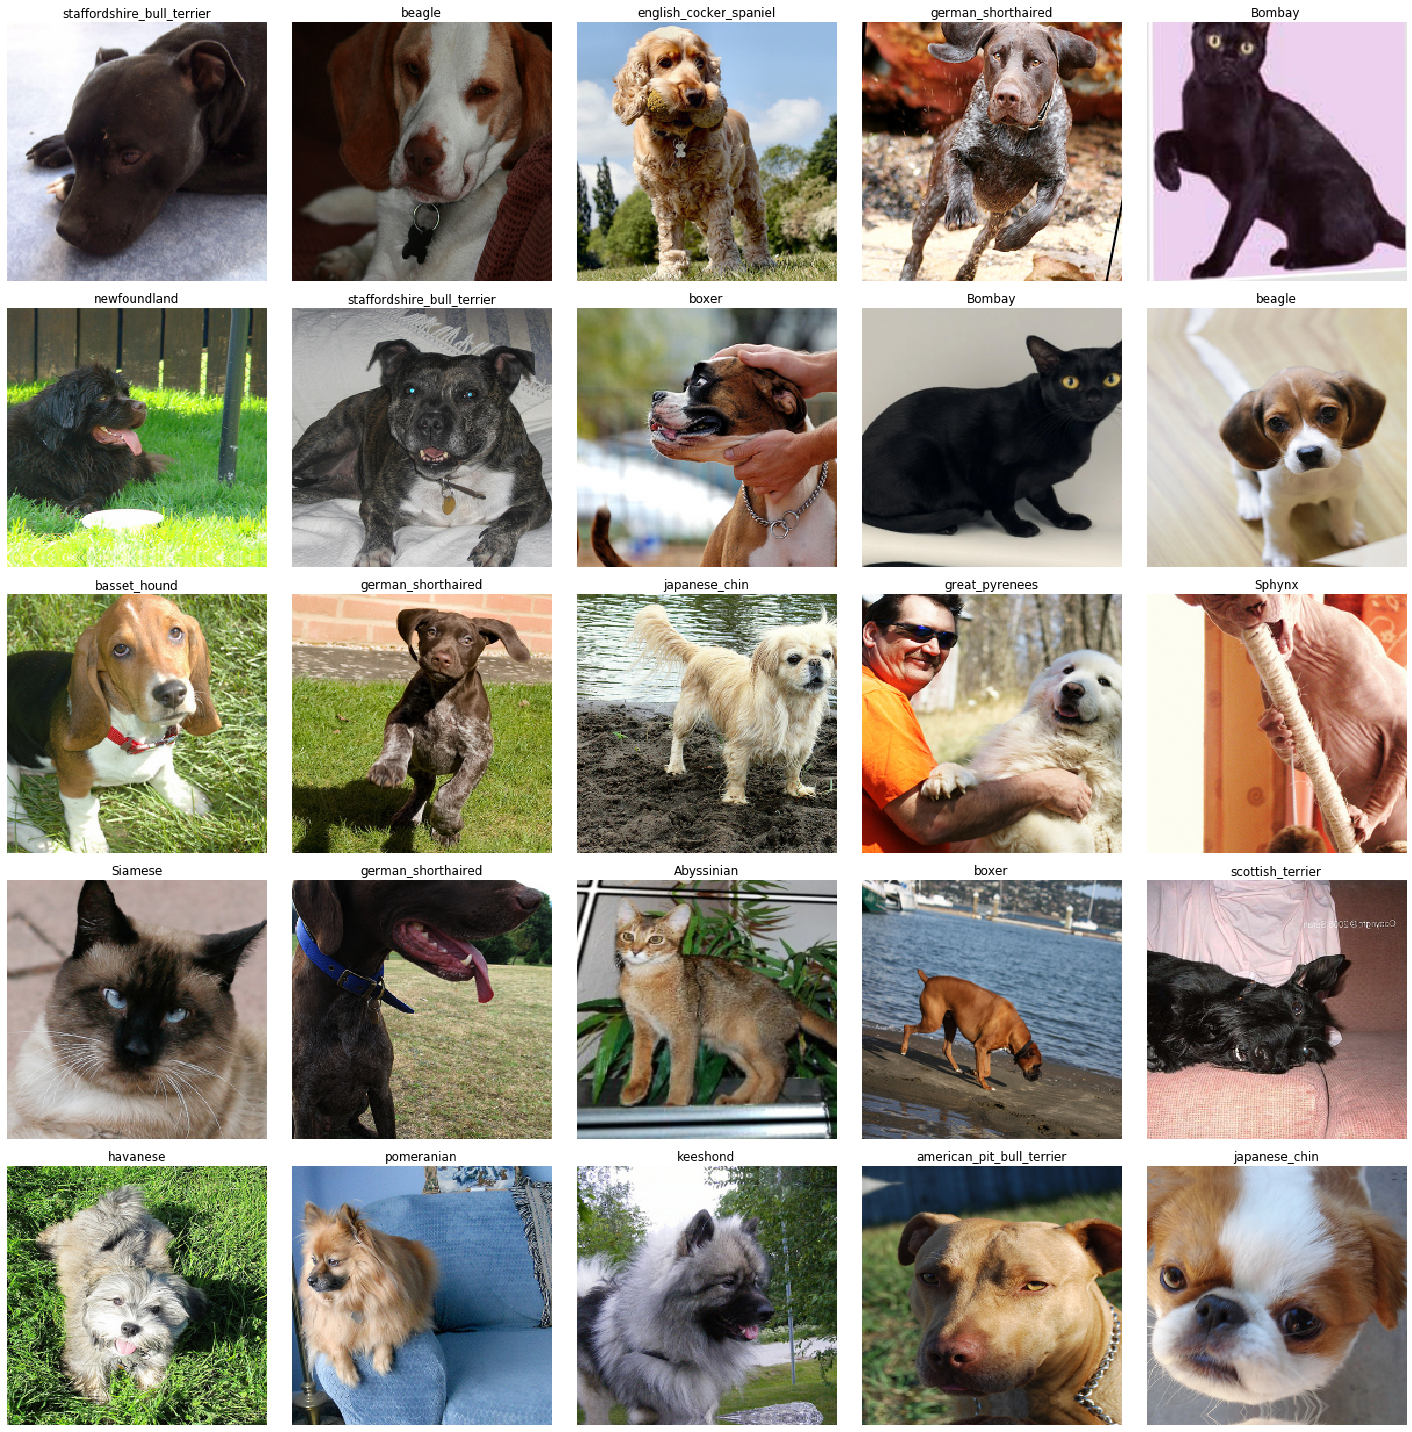

In [0]:
data.show_batch()

In [0]:
learn = create_cnn(data, models.resnet34, metrics=accuracy)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


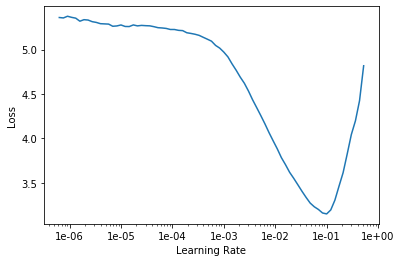

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4,1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


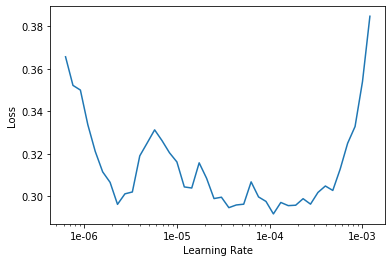

In [0]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(2,1e-5)

In [0]:
# Convert nn.Dropout to CustomDropout module
get_args = lambda dp : {"p" : dp.p}
convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)

# Turn on the stochasticity, I use verbose just to make sure it's working fine
switch_custom_dropout(learn.model,True,verbose=True)

Current active : True
Switching to : True
Current active : True
Switching to : True


In [0]:
def predict_entropy(img,n_times=10):
    pred = learn.predict_with_mc_dropout(img,n_times=n_times)
    probs = [prob[2].view((1,1) + prob[2].shape) for prob in pred]
    probs = torch.cat(probs)
    e = entropy(probs)
    return e
  
def plot_img_with_entropy(img,n_times=10):
    e = predict_entropy(img,n_times=n_times)
    img = to_np(img.data.permute(1,2,0))
    plt.imshow(img)
    plt.title(f"Entropy : {e[0]}")

In [0]:
!wget https://wikiofthrones.com/static/uploads/2017/08/night-king-compressed.jpg

--2019-11-28 19:32:00--  https://wikiofthrones.com/static/uploads/2017/08/night-king-compressed.jpg
Resolving wikiofthrones.com (wikiofthrones.com)... 104.24.96.26, 104.24.97.26, 2606:4700:30::6818:601a, ...
Connecting to wikiofthrones.com (wikiofthrones.com)|104.24.96.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48737 (48K) [image/jpeg]
Saving to: ‘night-king-compressed.jpg.1’

night-king-compress 100%[===================>]  47.59K  --.-KB/s    in 0.003s  

2019-11-28 19:32:00 (13.7 MB/s) - ‘night-king-compressed.jpg.1’ saved [48737/48737]



In [0]:
img = open_image("night-king-compressed.jpg")

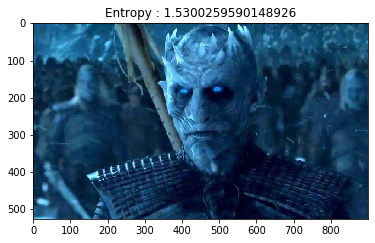

In [0]:
plot_img_with_entropy(img)

In [0]:
pred = learn.predict_with_mc_dropout(img,n_times=10)
probs = [prob[2].view((1,1) + prob[2].shape) for prob in pred]
probs = torch.cat(probs)
print(f"Highest class has probability : {probs.mean(dim=0).squeeze(0).max()}")

Highest class has probability : 0.9153898358345032


In [0]:
!wget https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png

--2019-11-28 19:34:31--  https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png
Resolving icatcare.org (icatcare.org)... 142.93.47.206
Connecting to icatcare.org (icatcare.org)|142.93.47.206|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1246129 (1.2M) [image/png]
Saving to: ‘Thinking-of-getting-a-cat.png.1’

Thinking-of-getting 100%[===================>]   1.19M   704KB/s    in 1.7s    

2019-11-28 19:34:34 (704 KB/s) - ‘Thinking-of-getting-a-cat.png.1’ saved [1246129/1246129]



In [0]:
img = open_image("Thinking-of-getting-a-cat.png")

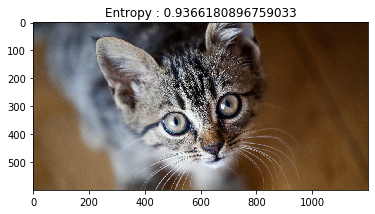

In [0]:
plot_img_with_entropy(img)

In [0]:
pred = learn.predict_with_mc_dropout(img,n_times=10)
probs = [prob[2].view((1,1) + prob[2].shape) for prob in pred]
probs = torch.cat(probs)
print(f"Highest class has probability : {probs.mean(dim=0).squeeze(0).max()}")

Highest class has probability : 0.7833359241485596


In [0]:
preds,y = get_preds_sample(learn)

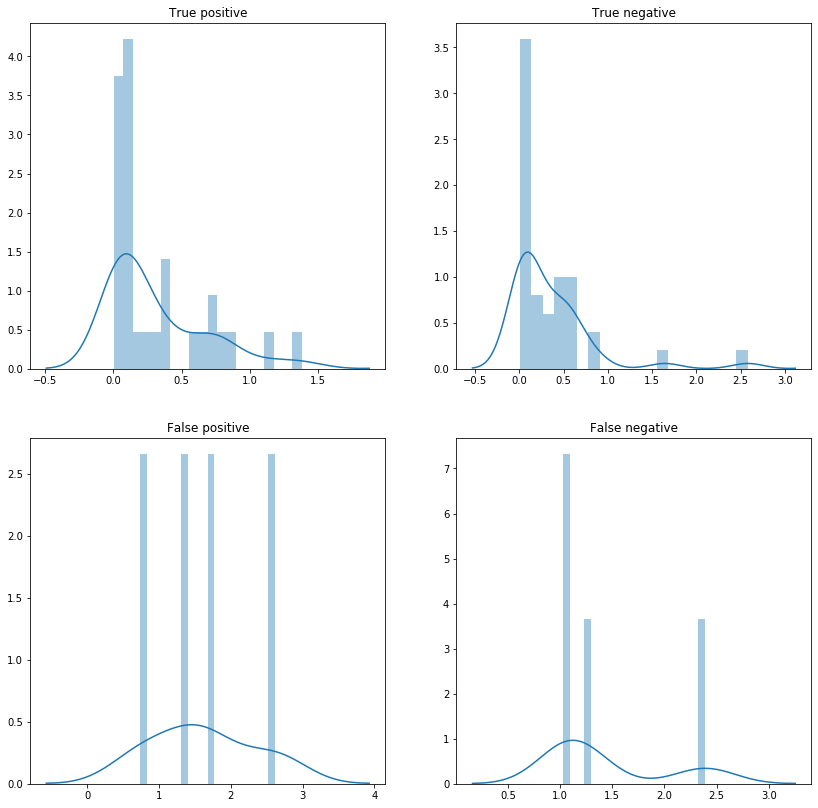

In [0]:
plot_hist_groups(preds,y,entropy,bins=20,figsize=(14,14))

### Text dataset with IMDB

In [0]:
from fastai.text import * 

path = untar_data(URLs.IMDB_SAMPLE)

df = pd.read_csv(path/'texts.csv')
df.head()

label                                               text  is_valid
0  negative  Un-bleeping-believable! Meg Ryan doesn't even ...     False
1  positive  This is a extremely well-made film. The acting...     False
2  negative  Every once in a long while a movie will come a...     False
3  positive  Name just says it all. I watched this movie wi...     False
4  negative  This movie succeeds at being one of the most u...     False

In [0]:
# Language model data
data_lm = TextLMDataBunch.from_csv(path, 'texts.csv')
# Classifier model data
data_clas = TextClasDataBunch.from_csv(path, 'texts.csv', vocab=data_lm.train_ds.vocab, bs=32)

learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5)
learn.fit_one_cycle(1, 1e-2)

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, 1e-3)

In [0]:
learn.save_encoder('ft_enc')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (799 items)
x: TextList
xxbos i found this film to funny from the start . xxmaj john xxmaj waters use of characters reminded of some of the down to earth characters from xxmaj fellini films . xxmaj christina xxmaj ricci has once again expanded her abilities in this film . xxmaj if you are looking for a fun movie without xxunk , i recommend this film .,xxbos * * * xxunk 
 
  xxmaj there are bad movies and then there are movies which are so awful that they become affectionately comical in their ineptness . xxmaj such is the case with xxmaj columbia xxmaj pictures ' ' xxmaj the xxmaj grudge . ' xxmaj this cinematic atrocity began when an otherwise well xxunk xxmaj american saw a xxmaj japanese made for xxup tv film ' xxmaj xxunk - on ' and was inspired to remake the movie in xxmaj english . xxmaj this began a virtual xxunk of bad decisions which xxunk the globe until it washed ashore in xxmaj orlando on xxmaj october xxunk , 2004 . 
 
 

In [0]:
learn.fit_one_cycle(1, 1e-2)

In [0]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/2., 5e-3))

In [0]:
learn.unfreeze()
learn.fit_one_cycle(1, slice(2e-3/100, 2e-3))

In [0]:
get_args = lambda dp : {"p" : dp.p}
convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)
switch_custom_dropout(learn.model,True,verbose=True)

Current active : True
Switching to : True
Current active : True
Switching to : True


In [0]:
pred,y = get_preds_sample(learn)

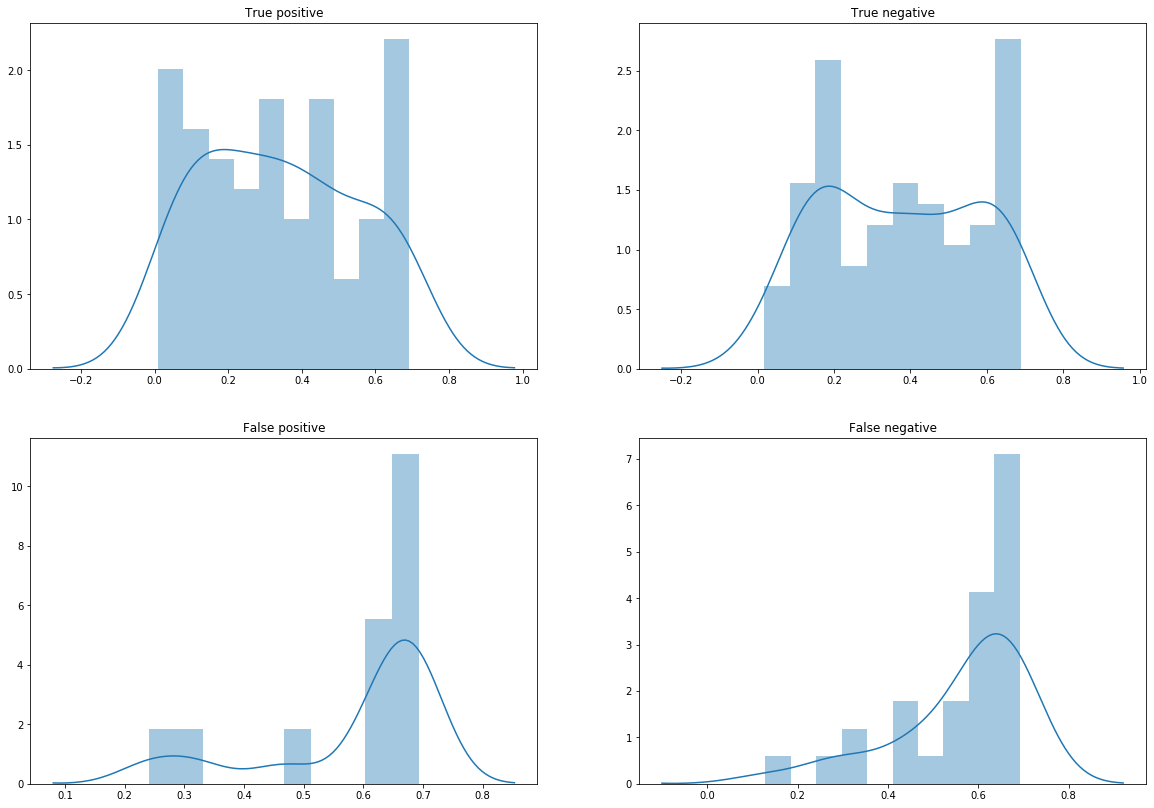

In [0]:
plot_hist_groups(pred,y,entropy,bins=10,figsize=(20,14))

In [0]:
H = entropy(pred)
idx = top_k_uncertainty(H,reverse=False)
for review in learn.data.valid_ds[idx]:
    print("_____________")
    print("Review : ")
    print(review)

_____________
Review : 
(Text xxbos xxmaj this film was a big disappointment . 
 
  i take the opposite view of the critics . xxmaj this is not a case of the material not being up to the level of the actors ; here the actors ( xxmaj bette xxmaj davis and xxmaj james xxmaj cagney ) are simply not up to the level of the material . xxmaj clark xxmaj gable and xxmaj claudette xxmaj colbert were every bit as big as xxmaj davis and xxmaj cagney , and look how xxmaj it xxmaj happened xxmaj one xxmaj night turned out - an all - time classic . xxmaj with a very similar story , xxmaj davis proves that she has no talent for comedy ( good thing for her that this is just about the only comedy she ever attempted ! ) xxmaj davis ' one - note performance oozes xxunk , but none of the nuances of xxmaj colbert 's acting in xxmaj it xxmaj happened xxmaj one xxmaj night . xxmaj cagney , who was a great comedy actor , just seems out - of - sync with his xxunk , xxmaj davis . xxmaj the script provides some 

In [0]:
idx = top_k_uncertainty(H,reverse=True)
for review in learn.data.valid_ds[idx]:
    print("_____________")
    print("Review : ")
    print(review)

_____________
Review : 
(Text xxbos a very cute movie with a great background provided by the city of xxmaj boston and xxmaj xxunk xxmaj park . xxmaj as a baseball fan and light movie addict , it hit a xxunk for me . xxmaj plenty of laughs and plenty of authentic baseball scenes with real xxunk and real references to past xxmaj bosox failures . xxmaj and how enjoyable was it to watch a movie with a baseball theme without having to endure an xxunk , over - the - hill , self - serving xxmaj kevin xxmaj xxunk attempting to make xxunk out of a critical audience ? xxmaj jimmy and xxmaj drew did a fine job as a young love - struck couple suffering from xxmaj jimmy 's xxmaj bosox " jones " . xxmaj it was a bit xxunk and out of left field , but there really are xxmaj xxunk fans that are that fanatic and live their lives through the xxunk of their beloved team . xxmaj the movie xxunk along at a fast pace and the ending , although predictable , had the charm and sentimentality of so many other p

### Tabular dataset with Adult income

In [0]:
from fastai.tabular import *

path = untar_data(URLs.ADULT_SAMPLE)
df = pd.read_csv(path/'adult.csv')
df.head()

age          workclass  fnlwgt  ... hours-per-week  native-country salary
0   49            Private  101320  ...             40   United-States  >=50k
1   44            Private  236746  ...             45   United-States  >=50k
2   38            Private   96185  ...             32   United-States   <50k
3   38       Self-emp-inc  112847  ...             40   United-States  >=50k
4   42   Self-emp-not-inc   82297  ...             50   United-States   <50k

[5 rows x 15 columns]

In [0]:
positive_idx = df.loc[df.salary == ">=50k"].index
negative_idx = df.loc[df.salary != ">=50k"].index

n = len(positive_idx) // 2
positive = np.random.choice(positive_idx,n,replace=False)

negative = np.random.choice(negative_idx,n,replace=False)

train_idx = np.concatenate([negative,positive])

valid_idx = df.index[~np.isin(df.index,train_idx)]

In [0]:
procs = [FillMissing, Categorify, Normalize]
dep_var = 'salary'
cat_names = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
data = TabularDataBunch.from_df(path, df, dep_var, valid_idx=valid_idx, procs=procs, cat_names=cat_names)

learn = tabular_learner(data, layers=[200,100],ps=[0.10,0.05], emb_szs={'native-country': 10}, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


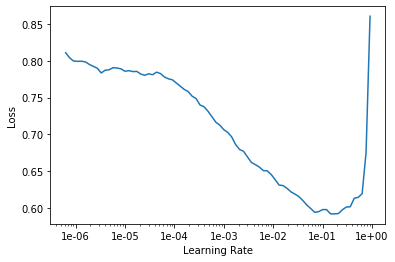

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(5, 1e-2)

In [0]:
get_args = lambda dp : {"p" : dp.p}
convert_layers(learn.model,nn.Dropout,CustomDropout,get_args)
switch_custom_dropout(learn.model,True,verbose=True)

Current active : True
Switching to : True
Current active : True
Switching to : True
Current active : True
Switching to : True


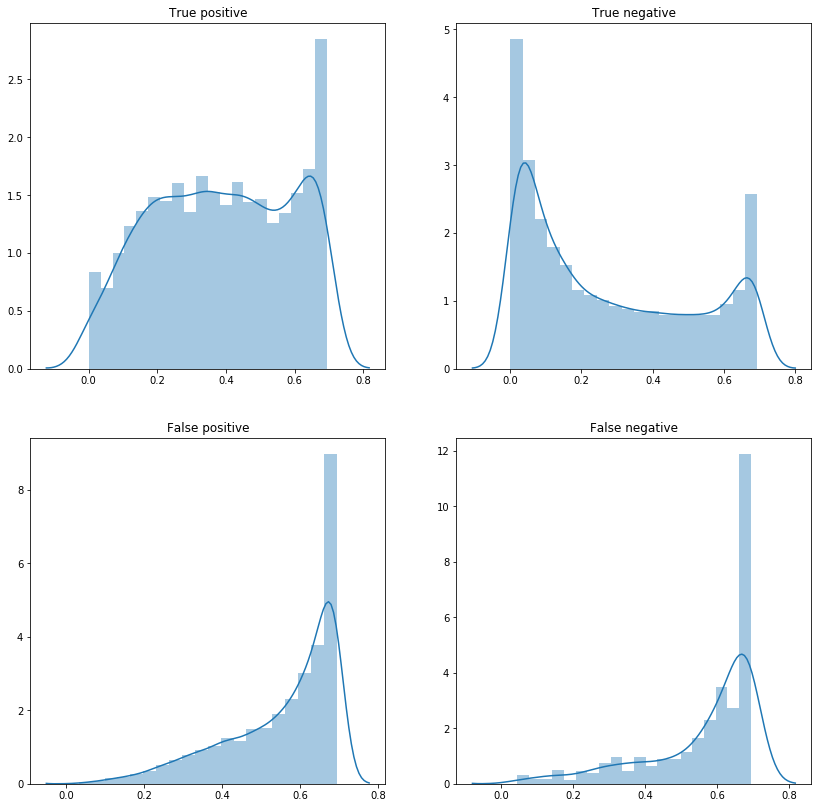

In [0]:
pred,y = get_preds_sample(learn)
plot_hist_groups(pred,y,entropy,bins=20,figsize=(14,14))

In [0]:
raw_pred,y = get_preds_sample(learn,activ= lambda x : x)

In [0]:
H = entropy(pred)
idx = top_k_uncertainty(H,reverse=True,k=2)
print("Most uncertain observations")
print(learn.data.valid_ds[idx])

print("_______________")

idx = top_k_uncertainty(H,reverse=False,k=2)
print("Most certain observations")
print(learn.data.valid_ds[idx])

Most uncertain observations
LabelList (2 items)
x: TabularList
age                           -0.505023
workclass                     State-gov
fnlwgt                         0.841152
education                       HS-grad
education-num                 -0.603602
marital-status       Married-civ-spouse
occupation             Transport-moving
relationship                    Husband
race                              Black
sex                                Male
capital-gain                   -0.19845
capital-loss                   -0.25881
hours-per-week                -0.197377
native-country            United-States
salary                             <50k
education-num_na                  False
Name: 14625, dtype: object,age                      -0.0437629
workclass              Self-emp-inc
fnlwgt                    -0.455311
education                 Bachelors
education-num               0.94263
marital-status        Never-married
occupation           Prof-specialty
relationship      